# Moive Recommendation System Using Alternating Least Squares (ALS) 
In this project, we build a recommender engine using Apache Spark. The recommendation model is trained in Spark using matrix factorization method and alternating least squares technique.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.sql.functions import explode, split, concat_ws, collect_list, avg

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

## Data transfering and simple observations

In [6]:
# create spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [7]:
# input csv files and display each table
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [8]:
display(movies)

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [9]:
display(ratings)

userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931
1,70,3.0,964982400
1,101,5.0,964980868
1,110,4.0,964982176
1,151,5.0,964984041
1,157,5.0,964984100


In [10]:
display(links)

movieId,imdbId,tmdbId
1,0114709,862
2,0113497,8844
3,0113228,15602
4,0114885,31357
5,0113041,11862
6,0113277,949
7,0114319,11860
8,0112302,45325
9,0114576,9091
10,0113189,710


In [11]:
display(tags)

userId,movieId,tag,timestamp
2,60756,funny,1445714994
2,60756,Highly quotable,1445714996
2,60756,will ferrell,1445714992
2,89774,Boxing story,1445715207
2,89774,MMA,1445715200
2,89774,Tom Hardy,1445715205
2,106782,drugs,1445715054
2,106782,Leonardo DiCaprio,1445715051
2,106782,Martin Scorsese,1445715056
7,48516,way too long,1169687325


In [12]:
# check minimum rating counts per user and per movie
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [13]:
# check how many movies have only one rating
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

### Conclusions from simple observations:
- The minimum rating counts per user is 20, means all users have enough data to analyze their movie preference.
- Some of the rated movies are only rated by 1 user (3446 out of 9724 movies), we need to be careful about this part of data.

## Spark DataFrame and OLAP

### Q1: The number of Users

In [17]:
userId_count1 = ratings.select('userId').distinct().count()
print('There are {} users rating the movies.'.format(userId_count1))
userId_count2 = tags.select('userId').distinct().count()
print('There are {} users giving tags to movies.'.format(userId_count2))

There are 610 users rating the movies.
There are 58 users giving tags to movies.

### Q2: The number of Movies

In [19]:
movie_count1 = movies.select('movieId').distinct().count()
movie_count2 = ratings.select('movieId').distinct().count()
movie_count3 = links.select('movieId').distinct().count()
movie_count4 = tags.select('movieId').distinct().count()
print('There are {} movies in total.'.format(movie_count1))
print('{} movies are rated.'.format(movie_count2))
print('{} movies are linked.'.format(movie_count3))
print('{} movies are given with tags.'.format(movie_count4))

There are 9742 movies in total.
9724 movies are rated.
9742 movies are linked.
1572 movies are given with tags.

### Q3:  How many movies are rated by users? List movies not rated before

In [21]:
movie_count2 = ratings.select('movieId').distinct().count()
print('{} movies are rated by users.'.format(movie_count2))
rating_counts = ratings.select("movieId", "timestamp").orderBy(["movieId"], ascending=[1]).groupBy("movieId").count()
movies_not_rated_before = rating_counts.select("movieId").filter(rating_counts["count"] == 1)
print("Movies that not rated before are:")
movies_not_rated_before.show(10)


9724 movies are rated by users.
Movies that not rated before are:
+-------+
movieId|
+-------+
 100044|
 100068|
 100106|
 100159|
 100194|
 100226|
 100277|
 100302|
 100304|
 100306|
+-------+
only showing top 10 rows

### Q4: List Movie Genres

In [23]:
genres = movies.withColumn('genre', explode(split(movies.genres, '\|')))
movie_genres = genres.select('genre').distinct().filter(genres.genre != '(no genres listed)')
display(movie_genres)

genre
Crime
Romance
Thriller
Adventure
Drama
War
Documentary
Fantasy
Mystery
Musical


### Q5: Movie for Each Category

In [25]:
movies_for_category = genres.filter(genres.genre != '(no genres listed)').groupBy('genre').agg(concat_ws(',', collect_list(genres.title)).alias('movie_lists'))
display(movies_for_category)

genre movie_lists Crime Heat (1995),Casino (1995),Money Train (1995),Get Shorty (1995),Copycat (1995),Assassins (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Dead Man Walking (1995),Dead Presidents (1995),Usual Suspects, The (1995),Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996),Crossing Guard, The (1995),Things to Do in Denver When You're Dead (1995),Hate (Haine, La) (1995),Bottle Rocket (1996),Taxi Driver (1976),Rumble in the Bronx (Hont faan kui) (1995),Young Poisoner's Handbook, The (1995),Bad Boys (1995),Amateur (1994),Batman Forever (1995),Clockers (1995),Devil in a Blue Dress (1995),Die Hard: With a Vengeance (1995),Doom Generation, The (1995),Hackers (1995),Judge Dredd (1995),Net, The (1995),Strange Days (1995),Bushwhacked (1995),Heavenly Creatures (1994),Kiss of Death (1995),New Jersey Drive (1995),New York Cop (Nyû Yôku no koppu) (1993),Natural Born Killers (1994),Once Were Warriors (1994),Léon: The Professional (a.k.a. The Professional) (Léon) (1994),Pulp Fiction (1994),Shawshank Redemption, The (1994),Tales from the Hood (1995),Clear and Present Danger (1994),Crow, The (1994),Mask, The (1994),Bad Company (1995),Faster Pussycat! Kill! Kill! (1965),Jason's Lyric (1994),Above the Rim (1994),Beverly Hills Cop III (1994),Carlito's Way (1993),Fresh (1994),Getaway, The (1994),Hard Target (1993),Jimmy Hollywood (1994),Judgment Night (1993),Killing Zoe (1994),Menace II Society (1993),Perfect World, A (1993),RoboCop 3 (1993),Romeo Is Bleeding (1993),Serial Mom (1994),Striking Distance (1993),True Romance (1993),Escort, The (Scorta, La) (1993),Batman (1989),Silence of the Lambs, The (1991),Love and a .45 (1994),Fargo (1996),Primal Fear (1996),Courage Under Fire (1996),Substitute, The (1996),Mulholland Falls (1996),Heaven's Prisoners (1996),Striptease (1996),Trainspotting (1996),American Buffalo (1996),Ransom (1996),Godfather, The (1972),Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992),Bound (1996),Carpool (1996),Kansas City (1996),Nothing to Lose (1994),Supercop 2 (Project S) (Chao ji ji hua) (1993),Bulletproof (1996),Some Like It Hot (1959),Charade (1963),To Catch a Thief (1955),Laura (1944),Thin Man, The (1934),Beat the Devil (1953),Last Man Standing (1996),Set It Off (1996),2 Days in the Valley (1996),Freeway (1996),Die Hard (1988),Normal Life (1996),Crossfire (1947),Fish Called Wanda, A (1988),Bonnie and Clyde (1967),Dial M for Murder (1954),Reservoir Dogs (1992),Basic Instinct (1992),Funeral, The (1996),Return of the Pink Panther, The (1975),Wallace & Gromit: The Wrong Trousers (1993),Grifters, The (1990),Tie Me Up! Tie Me Down! (¡Átame!) (1990),Clockwork Orange, A (1971),Goodfellas (1990),Killer, The (Die xue shuang xiong) (1989),Psycho (1960),Godfather: Part II, The (1974),Once Upon a Time in America (1984),Sting, The (1973),Miller's Crossing (1990),Touch of Evil (1958),Femme Nikita, La (Nikita) (1990),Chinatown (1974),M (1931),Manchurian Candidate, The (1962),Fried Green Tomatoes (1991),Big Sleep, The (1946),Cape Fear (1962),Blood and Wine (Blood & Wine) (1996),Albino Alligator (1996),Batman Returns (1992),Sneakers (1992),Beavis and Butt-Head Do America (1996),La Cérémonie (1995),Hamlet (1996),Thieves (Voleurs, Les) (1996),Murder at 1600 (1997),Metro (1997),Gridlock'd (1997),Lost Highway (1997),Donnie Brasco (1997),Best Men (1997),Grosse Pointe Blank (1997),Face/Off (1997),Cop Land (1997),Desperate Measures (1998),Hoodlum (1997),L.A. Confidential (1997),Kiss the Girls (1997),U Turn (1997),Playing God (1997),Switchback (1997),Gang Related (1997),Deceiver (1997),Incognito (1997),Red Corner (1997),Man Who Knew Too Little, The (1997),Midnight in the Garden of Good and Evil (1997),Jackie Brown (1997),Big Lebowski, The (1998),Hard Rain (1998),Fallen (1998),Replacement Killers, The (1998),B. Monkey (1998),Palmetto (1998),King of New York (1990),Twilight (1998),U.S. Marshals (1998),Suicide Kings (1997),Newton Boys, The (1998),Wild Things (1998),Fi

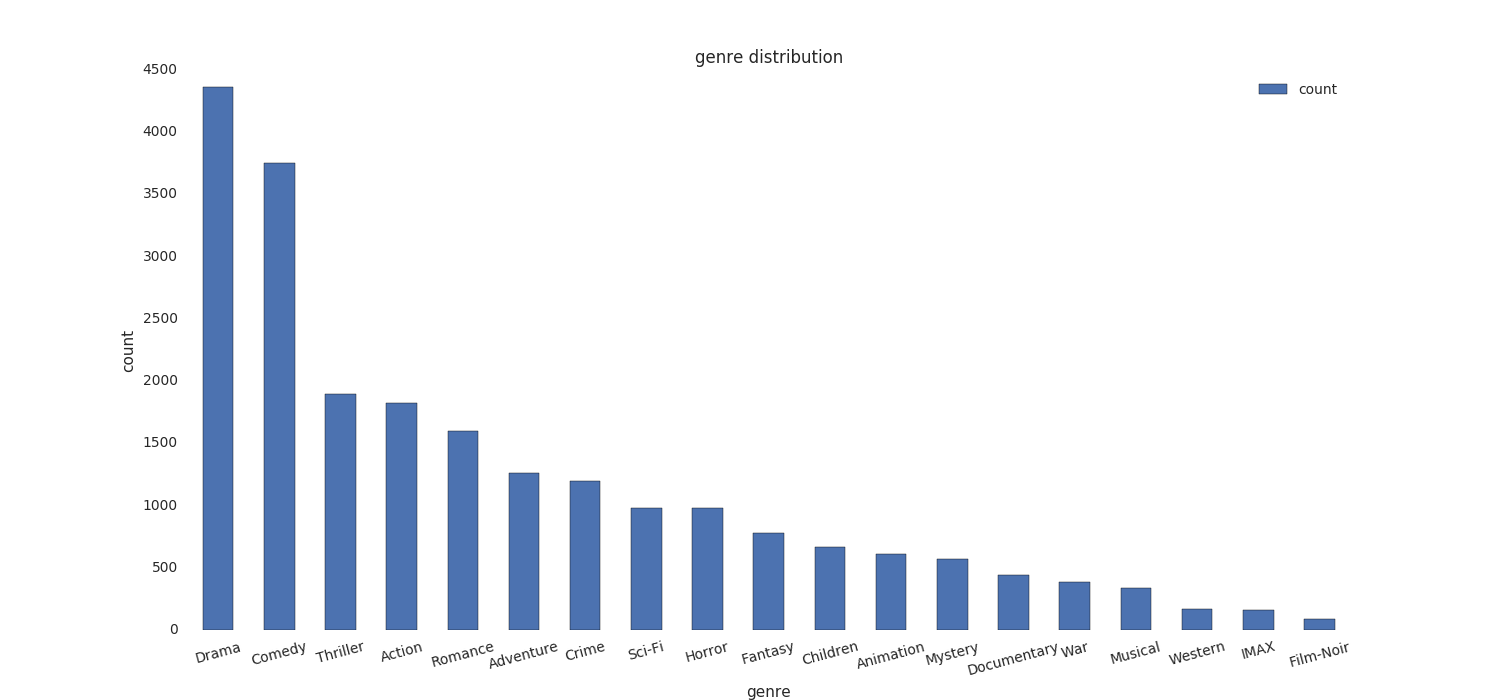

In [26]:
counts_for_category = genres.filter(genres.genre != '(no genres listed)').groupBy('genre').count()
counts_pd = counts_for_category.orderBy('count', ascending = [0]).toPandas()
fig1, ax1 = plt.subplots(figsize=(15,7))
counts_pd.plot.bar(ax = ax1, x='genre', y = 'count', rot = 15)
ax1.set_xlabel('genre')
ax1.set_ylabel('count')
ax1.set_title('genre distribution')
display(fig1)

### Conclusions from OLAP:
- Most of the movies are rated, and only 0.19% are not rated 
- There are 20 unique genres in our dataset, including "no genres listed".
- Drama, Comedy are the top 2 most common genre and their frequencies are two times more than other gernes.

## Exploratory Data Analysis (EDA)

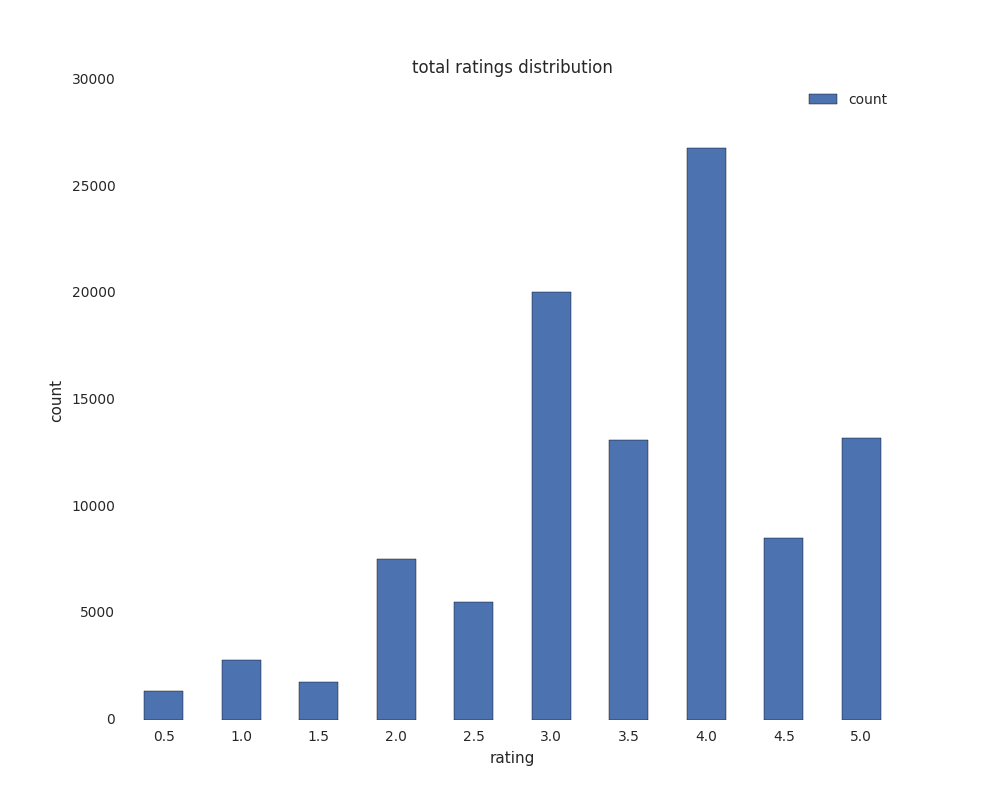

In [29]:
rating_distribution_pd = ratings.select('rating').orderBy('rating').groupBy('rating').count().toPandas()
fig2, ax2 = plt.subplots(figsize=(10,8))
rating_distribution_pd.plot.bar(ax = ax2, x='rating', y = 'count', rot = 0)
ax2.set_ylabel('count')
ax2.set_title('total ratings distribution')
display(fig2)

In [30]:
movie_ratings = ratings.select('movieId','rating').orderBy('movieId')
movie_average = movie_ratings.groupBy('movieId').agg(avg(movie_ratings.rating).alias('avg_rating'))
display(movie_average)

movieId,avg_rating
1,3.9209302325581397
10,3.496212121212121
100,2.7857142857142856
100044,4.0
100068,3.5
100083,3.5
100106,3.5
100159,4.5
100163,2.9
100194,4.5


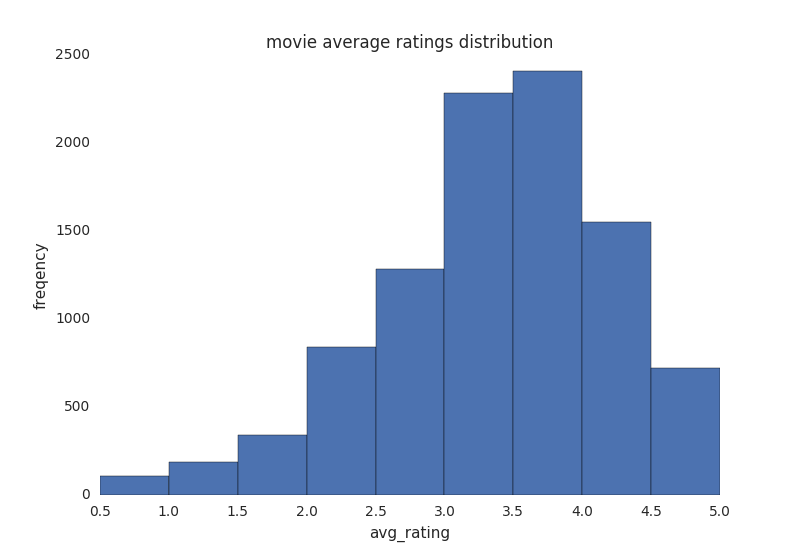

In [31]:
fig3, ax3 = plt.subplots()
pandas_movie_avg = movie_average.toPandas()
pandas_movie_avg.hist(ax=ax3, bins = 9)
ax3.set_xlabel('avg_rating')
ax3.set_ylabel('freqency')
ax3.set_title('movie average ratings distribution')
display(fig3)

In [32]:
user_ratings = ratings.select('userId','rating').orderBy('userId')
user_average = user_ratings.groupBy('userId').agg(avg(user_ratings.rating).alias('avg_rating'))
display(user_average)

userId,avg_rating
1,4.366379310344827
10,3.2785714285714285
100,3.945945945945946
101,3.557377049180328
102,3.357142857142857
103,3.907161803713528
104,3.5073260073260073
105,4.116343490304709
106,4.4393939393939394
107,3.911764705882353


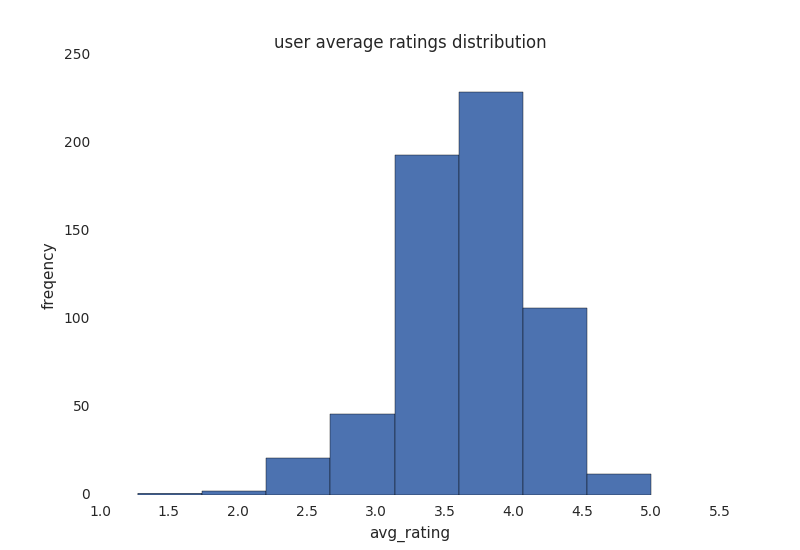

In [33]:
fig4, ax4 = plt.subplots()
pandas_user_avg = user_average.toPandas()
pandas_user_avg.hist(ax=ax4, bins = 8)
ax4.set_xlabel('avg_rating')
ax4.set_ylabel('freqency')
ax4.set_title('user average ratings distribution')
display(fig4)

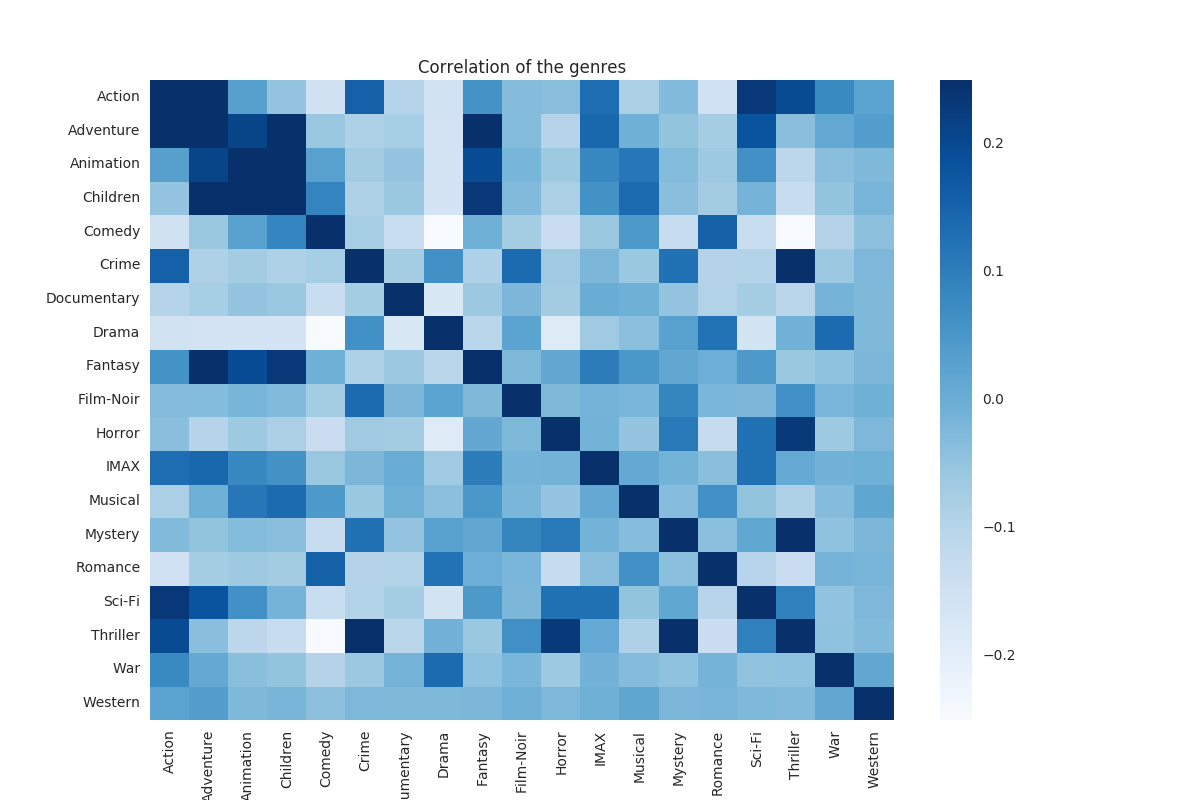

In [34]:
movies_pd = movies.toPandas()
unique_genres = sorted(movies_pd.genres.str.split("|", expand = True).stack().unique())
# create binary features for each unique genre
genre_dict = {genre:movies_pd.genres.apply(lambda s: s.find(genre) >= 0) for genre in unique_genres if genre != "(no genres listed)"}
genre_df_pd = pd.DataFrame(data = genre_dict)
# plot correlation matrix of the genres
corr = genre_df_pd.corr()
fig5, ax5 = plt.subplots(figsize = (12, 8))
plt.clf()
sns.heatmap(corr, cmap = 'Blues', vmin = -0.25, vmax = 0.25, center = 0)
plt.title("Correlation of the genres")
display(fig5)

In [35]:
# cluster genres using hierarchical clustering
sns.clustermap(corr, cmap = 'Blues', vmin = -0.25, vmax = 0.25, center = 0, figsize = (12, 8))
# plt.savefig("clustermap.png", bbox_inches = "tight")

Out[ 78 ]: <seaborn.matrix.ClusterGrid at 0x7f030bd49198>

![1](https://raw.githubusercontent.com/YuhaoChen830/Recommendation_System_ALS/master/clustermap.png)

### Conclusions from EDA:
- The most common socre is 4.0 and the rarest score is 0.5. About 81% of the ratings are higher than or equal to 3.0. 
- Amost half movies have average socre between 3 and 4..
- The average socre of the movies that an user has watched is mostly distributed between 3.0 and 4.5.
- In the upper left part of clustermap:
  - Drama and War combine together.
  - Crime, Mystery and Thriller are highly correlated.
  - Horror correlate with Thriller most, then Mystery, but no Crime.
  - Film-Noir is moderately related with Crime, Mystery and Thriller.
- In the middle part of clustermap:
  - Animation, Children, Adverture and Fantasy form a big cluster.
  - Action ofter equal to Sci-Fi.
  - IMAX are close to the Action, Sci-Fi combination.
- In the lower right part of clustermap:
  - Musical, Comedy and Romance correlated moderately.
  - Documentary and Western are not close to any other genres.

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [39]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation

In [40]:
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [41]:
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()

In [42]:
# check three rows
rating_data.take(3)

Out[ 107 ]: [(1, 1, 4.0), (1, 3, 4.0), (1, 6, 4.0)]

In [43]:
df_rating_data = spark.createDataFrame(rating_data)
df_rating_data = df_rating_data.withColumnRenamed('_1', 'userId').withColumnRenamed('_2', 'movieId').withColumnRenamed('_3', 'rating')
df_rating_data.show()

+------+-------+------+
userId|movieId|rating|
+------+-------+------+
 1| 1| 4.0|
 1| 3| 4.0|
 1| 6| 4.0|
 1| 47| 5.0|
 1| 50| 5.0|
 1| 70| 3.0|
 1| 101| 5.0|
 1| 110| 4.0|
 1| 151| 5.0|
 1| 157| 5.0|
 1| 163| 5.0|
 1| 216| 5.0|
 1| 223| 3.0|
 1| 231| 5.0|
 1| 235| 4.0|
 1| 260| 5.0|
 1| 296| 3.0|
 1| 316| 3.0|
 1| 333| 5.0|
 1| 349| 4.0|
+------+-------+------+
only showing top 20 rows

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [45]:
train, validation, test = df_rating_data.randomSplit([0.6,0.2,0.2],seed = 7856)

In [46]:
train.cache()

Out[ 110 ]: DataFrame[userId: bigint, movieId: bigint, rating: double]

In [47]:
validation.cache()

Out[ 111 ]: DataFrame[userId: bigint, movieId: bigint, rating: double]

In [48]:
test.cache()

Out[ 112 ]: DataFrame[userId: bigint, movieId: bigint, rating: double]

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [50]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            als = ALS(rank=rank, maxIter=num_iters, regParam=reg, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
            model = als.fit(train_data)
            # make prediction
            predictions = model.transform(validation_data)
            # set evaluator
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
            # get the RMSE
            rmse = evaluator.evaluate(predictions)
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [51]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9763247847628346
6 latent factors and regularization = 0.1: validation RMSE is 0.9135436774962692
6 latent factors and regularization = 0.2: validation RMSE is 0.8923552027027722
6 latent factors and regularization = 0.4: validation RMSE is 0.9602346357681362
6 latent factors and regularization = 0.8: validation RMSE is 1.179126371602815
8 latent factors and regularization = 0.05: validation RMSE is 0.98732390717732
8 latent factors and regularization = 0.1: validation RMSE is 0.9128343506940145
8 latent factors and regularization = 0.2: validation RMSE is 0.891346018798004
8 latent factors and regularization = 0.4: validation RMSE is 0.9604495274003404
8 latent factors and regularization = 0.8: validation RMSE is 1.1791112988291472
10 latent factors and regularization = 0.05: validation RMSE is 0.9944726753219287
10 latent factors and regularization = 0.1: validation RMSE is 0.9160468684931149
10 latent factors and regularization = 0.2: validation RMSE is 0.8931297720816374
10 latent factors and regularization = 0.4: validation RMSE is 0.9600830003959486
10 latent factors and regularization = 0.8: validation RMSE is 1.1791177710374703
12 latent factors and regularization = 0.05: validation RMSE is 0.9975343380095401
12 latent factors and regularization = 0.1: validation RMSE is 0.9159376719872818
12 latent factors and regularization = 0.2: validation RMSE is 0.8923098716684146
12 latent factors and regularization = 0.4: validation RMSE is 0.9606543349373416
12 latent factors and regularization = 0.8: validation RMSE is 1.179114652180703
14 latent factors and regularization = 0.05: validation RMSE is 1.0095423359496583
14 latent factors and regularization = 0.1: validation RMSE is 0.9155904027879159
14 latent factors and regularization = 0.2: validation RMSE is 0.8921235138547918
14 latent factors and regularization = 0.4: validation RMSE is 0.9605971126420316
14 latent factors and regularization = 0.8: validation RMSE is 1.1791069131166232

The best model has 8 latent factors and regularization = 0.2
Total Runtime: 815.07 seconds

In [52]:
def plot_learning_curve(iter_array, train_data, validation_data, reg, rank):
  error_list = []
  for num_iters in iter_array:
    als = ALS(rank=rank, maxIter=num_iters, regParam=reg, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
    model = als.fit(train_data)
    predictions = model.transform(validation_data)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    error_list.append(rmse)
    
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  ax.plot(iter_array, error_list)
  ax.set_xlabel('iterations')
  ax.set_ylabel('RMSE')
  display(fig)

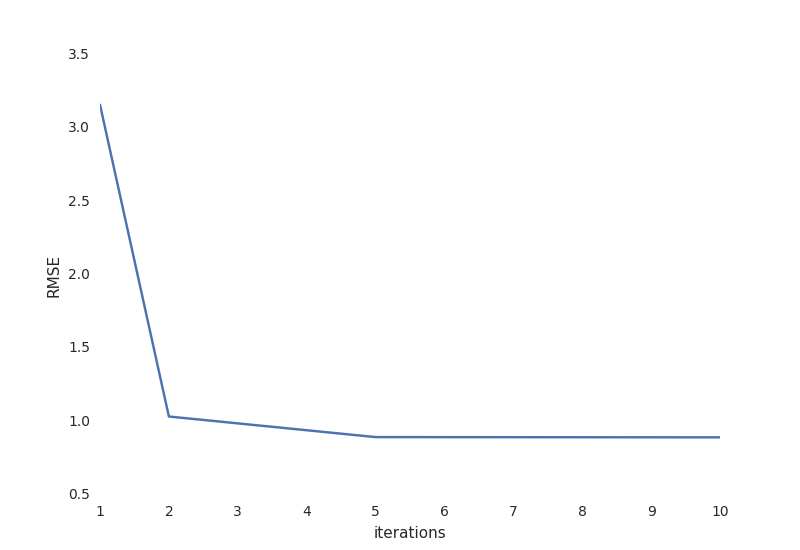

In [53]:
iter_array = [1, 2, 5, 10]
plot_learning_curve(iter_array, train, validation, 0.2, 10)

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [55]:
test_predictions = final_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
test_rmse = evaluator.evaluate(test_predictions)
print('The RMSE of the test prediction is {}'.format(str(test_rmse)))

The RMSE of the test prediction is 0.891256408443999

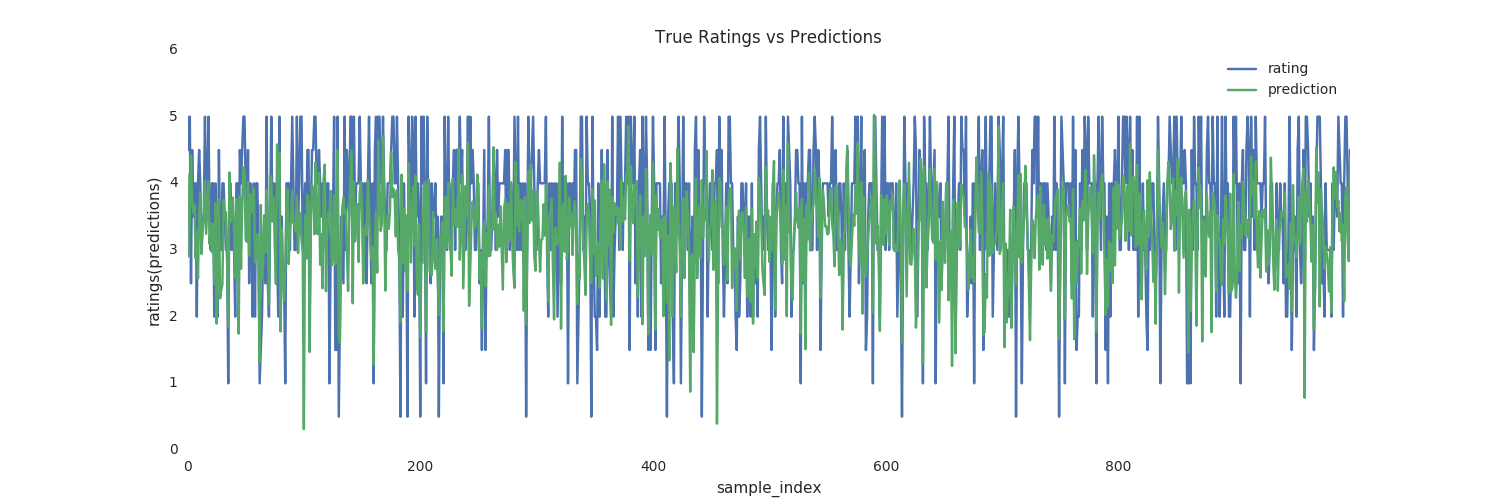

In [56]:
prediction_df = test_predictions.select('rating', 'prediction').toPandas()
fig6, ax6 = plt.subplots(figsize = (15,5))
prediction_df.sample(n = 1000, random_state = 123).reset_index(drop = True).plot.line(ax = ax6)
ax6.set_xlabel('sample_index')
ax6.set_ylabel('ratings(predictions)')
ax6.set_title('True Ratings vs Predictions')
display(fig6)

### Conclusions from ALS model generation:
- I first splited the whole dataset into train, validation and test parts.
- I did grid search to `rank` and `regParam` using the train and validation parts of data, then return the best model.
- Then I ploted the learning curve of the model based on different `maxIter` parameters and found out that 10 is a proper assumption for this parameter.
- I inplemented the final model and did prediction on test data and reached 0.89 RMSE, which demenstrate the correctness of the final model.
- Finally, I randomly pick 1000 samples from test data and draw the line plots for true and predictive ratings. The line plots share the same trend, which proves they have good correlation.